<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/06/PTE_DL6_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN finomhangolás

Az ImageNet adathalmaz több mint 1 millió gyakorló képből áll.

**Mi van, ha nincs túl sok képünk?**
 1. menjünk és gyűjtsünk sokkal több adatot
 2. használjuk az ImageNet adathalmazból tanult tudást
 
Az 1 millió ImageNet-képen betanított neurális hálózat használatával **jó belső reprezentációval** kell rendelkeznie (kerek tárgyak, szemek, szöveg stb. megtalálása) a különböző tárgyak fotóihoz. A transzfer tanulás lényege, hogy ezekre a reprezentációkra támaszkodunk. 

Általánosságban a transzfer tanulás során azt szeretnénk, hogy minél több információ kerüljön át az egyik adatkészletből a másikba. Mivel az első rétegek általánosak, nem kell sokat változniuk, így jóval alacsonyabb tanulási sebesség is megfelel. Az utolsó rétegek feladatspecifikusabbak, így ezeket jobban kell képeznünk (magasabb tanulási rátával).


In [ ]:
%tensorflow_version 2.x

In [ ]:
from PIL import Image
from pathlib import Path
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Kutyák és macskák

A Kaggle "Kutyák és macskák" verseny adatait fogjuk használni. A dolgok megnehezítése érdekében a gyakorló képek egy apró részhalmazára korlátozódunk, 300 képre a kutyák és 300 képre a macskák esetében.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg">

https://www.kaggle.com/c/dogs-vs-cats/

Az ImageNet előre betanított modelljei tökéletes választásnak tűnnek, mivel az ImageNet több mint 100 különböző kutyafajtát tartalmaz, így a hálózat súlyainak kivételesnek kell lenniük a kutyák osztályozásakor.



In [ ]:
# download the prepared dataset
!gdown --id 1Gj4T1NIThIx_Py4hd2YbAGpVJhpUlCVK

Downloading...
From: https://drive.google.com/uc?id=1Gj4T1NIThIx_Py4hd2YbAGpVJhpUlCVK
To: /content/dogscats.zip
100% 572M/572M [00:06<00:00, 82.1MB/s]


In [ ]:
# unzip it
!unzip -q dogscats.zip

In [ ]:
train_dogs = list(Path('train/dog/').glob('*'))
train_cats = list(Path('train/cat/').glob('*'))

print(f'#Training images: {len(train_cats), len(train_dogs)}')

test_dogs = list(Path('test/dog/').glob('*'))
test_cats = list(Path('test/cat/').glob('*'))

print(f'#Test images: {len(test_cats), len(test_dogs)}')

#Training images: (300, 300)
#Test images: (12200, 12200)


### A képek többsége korrekt, de néhány kép problémás lehet!

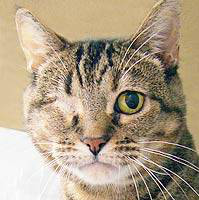

In [ ]:
Image.open('train/cat/cat.11368.jpg')

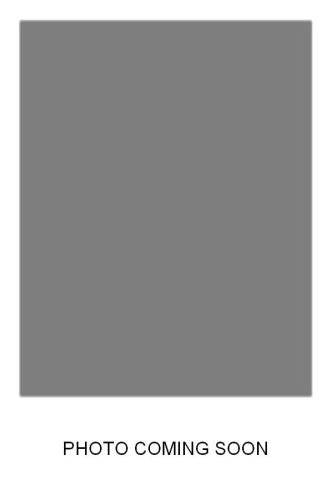

In [ ]:
Image.open('train/cat/cat.11184.jpg')

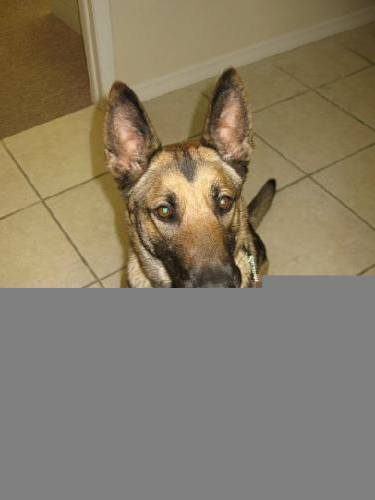

In [ ]:
Image.open('train/dog/dog.11191.jpg')

### Modell létrehozása

A ResNet50-et fogjuk használni, két modellt készítünk:
 
 1. véletlenszerűen inicializált
 2. előre képzett imagenet-en
 
Mivel az ImageNet 1000 kategóriát tartalmaz, az utolsó réteget úgy kell módosítanunk, hogy 1000 helyett 1 neuron legyen. Egy bináris osztályozót fogunk betanítani (0-1), hogy jelezze, hogy macska vagy kutya van-e a képen. 

 - bináris keresztentrópia
 - sigmoid a softmax helyett
   - softmax egy neuronnal $\to$ konstans 1 előrejelzés mindig
   A modellek beállítása
Használhattunk volna 2 neuront is kategorikus crossentrópiával és softmax-szal.

In [ ]:
# we could set classes=1, but the default activation is softmax
# softmax with one neuron is not the best idea...
#basemodel = tf.keras.applications.ResNet50(weights=None, include_top=False)
base_model = ResNet50(weights=None, include_top=False)
base_pretrained_model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

Az utolsó réteg eltávolítása és egy új modell létrehozása, amelynek a végén 1 neuron van szigmoid aktiválással.

In [ ]:
x = base_pretrained_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
pretrained_model = Model(inputs=base_pretrained_model.input, outputs=predictions)

Az előre betanított modell esetében az utolsó réteg kivételével az összes réteget befagyasztjuk.

In [ ]:

for i in pretrained_model.layers[:-1]:
    i.trainable = False

Nézzük meg mindkét modellt!

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Dataloader

Korábban csak betöltöttük az összes adatot a memóriába, és adtuk át a neurális hálózatnak. Nagyobb datset esetén gyakran előfordul, hogy egyszerűen nem fér el a RAM-ban. A datagenerátorok olyan függvények, amelyek egyszerre egy adag adatot szolgáltatnak.

A Tf-keras rendelkezik egy beépített ImageDataGeneratorral, itt ezt fogjuk használni. A képnövelés a dataloader-en belül is elvégezhető.

A kategóriákat a mappanevekből illesztjük össze.

In [ ]:
def imagenet_convert(img):
    img  = img.astype(float)[...,::-1] # RGB --> BGR
    img -= [103.939, 116.779, 123.68]
    return img

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
#train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function=imagenet_convert)

# Note that the validation data should not be augmented!
#test_datagen = ImageDataGenerator( rescale = 1.0/255. , preprocessing_function=imagenet_convert )


In [ ]:
train_datagenerator = ImageDataGenerator(preprocessing_function=imagenet_convert)
test_datagenerator  = ImageDataGenerator(preprocessing_function=imagenet_convert)

train_datagenerator = train_datagenerator.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

test_datagenerator = test_datagenerator.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary')

Found 600 images belonging to 2 classes.
Found 24400 images belonging to 2 classes.


Állítsuk össze a modelleket az Adam optimalizálóval $10^{-4}$ tanulási rátával.

In [ ]:
model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
pretrained_model.compile(optimizer=Adam(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### A modelleket 25 korszakon keresztül képezzük, és minden 5. korszak után elvégezzük el a validálást. 

A képzési idő elég alacsony egy korszak esetében, a validálás azonban sokkal lassabb. Ez azért történik, mert 40x több képet kell validálnunk, mint amennyit a képzéshez használunk. 

In [ ]:
model.fit(train_datagenerator, steps_per_epoch=len(train_datagenerator),
          validation_data=test_datagenerator, validation_steps = len(test_datagenerator),
          validation_freq=5, epochs=25)

Epoch 1/25
38/38 [==============================] - 54s 441ms/step - loss: 0.8360 - accuracy: 0.5217
Epoch 2/25
38/38 [==============================] - 15s 402ms/step - loss: 0.7611 - accuracy: 0.5600
Epoch 3/25
38/38 [==============================] - 15s 401ms/step - loss: 0.6830 - accuracy: 0.6533
Epoch 4/25
38/38 [==============================] - 15s 400ms/step - loss: 0.6061 - accuracy: 0.6700
Epoch 5/25
38/38 [==============================] - 216s 6s/step - loss: 0.6929 - accuracy: 0.6133 - val_loss: 1.0809 - val_accuracy: 0.5000
Epoch 6/25
38/38 [==============================] - 15s 400ms/step - loss: 0.5880 - accuracy: 0.6917
Epoch 7/25
38/38 [==============================] - 15s 400ms/step - loss: 0.5715 - accuracy: 0.7017
Epoch 8/25
38/38 [==============================] - 15s 400ms/step - loss: 0.5984 - accuracy: 0.7117
Epoch 9/25
38/38 [==============================] - 15s 399ms/step - loss: 0.5446 - accuracy: 0.7233
Epoch 10/25
38/38 [==============================] 

In [ ]:
pretrained_model.fit(train_datagenerator, steps_per_epoch=len(train_datagenerator),
                     validation_data=test_datagenerator, validation_steps = len(test_datagenerator),
                     validation_freq=5, epochs=25)

Epoch 1/25
38/38 [==============================] - 9s 135ms/step - loss: 0.6921 - accuracy: 0.5783
Epoch 2/25
38/38 [==============================] - 5s 134ms/step - loss: 0.6003 - accuracy: 0.6883
Epoch 3/25
38/38 [==============================] - 5s 135ms/step - loss: 0.5289 - accuracy: 0.7883
Epoch 4/25
38/38 [==============================] - 5s 135ms/step - loss: 0.4692 - accuracy: 0.8517
Epoch 5/25
38/38 [==============================] - 203s 5s/step - loss: 0.4194 - accuracy: 0.9000 - val_loss: 0.4073 - val_accuracy: 0.8917
Epoch 6/25
38/38 [==============================] - 5s 134ms/step - loss: 0.3780 - accuracy: 0.9250
Epoch 7/25
38/38 [==============================] - 5s 135ms/step - loss: 0.3445 - accuracy: 0.9383
Epoch 8/25
38/38 [==============================] - 5s 134ms/step - loss: 0.3150 - accuracy: 0.9550
Epoch 9/25
38/38 [==============================] - 5s 133ms/step - loss: 0.2897 - accuracy: 0.9583
Epoch 10/25
38/38 [==============================] - 202s 5

# Összefoglaló

Mindkét hálózat idővel jobb lett, de a véletlenszerűen inicializált hálózat csak <70%-os pontosságot tudott elérni (néhány ötlettel biztosan sokkal jobbat is elérhetnénk), míg az előre betanított modell >97%-os pontosságot ért el.   
Emellett az előre betanított modell esetében a képzési idő ~50%-kal alacsonyabb volt minden korszak esetében.

https://www.kaggle.com/c/dogs-vs-cats/leaderboard   
6 évvel ezelőtt a győztes 98,9%-ot ért el, a 10. helyezett 97,9%-ot, a 30. helyezett 96,7%-ot (de egy másik tesztkészleten).

**Ezeket az eredményeket ~3 perces edzéssel értük el (a validálási időt nem számítva).**


### További fejlesztések
 - az adathalmaz megtisztítása, a tévesen címkézett képek eltávolítása
 - adatbővítés
 - tesztidő növelése
 - a tanulás ütemezése
 

In [ ]:
import numpy as np

In [ ]:
np.genfromtxt